### 1. Data Cleaning and Preprocessing
Import necessary packages

In [1]:
import pandas as pd 
import re 
import string 
import nltk
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk.corpus  
from nltk.text import Text 
from PIL import Image
from textblob import TextBlob
%matplotlib inline

from nltk.corpus import webtext
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk import bigrams
import itertools
import collections


import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from scipy.cluster.hierarchy import ward, dendrogram, single,complete,average,weighted,centroid,median
from scipy.spatial.distance import pdist
import spacy
import math
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel

/Users/briannamueller/.local/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


Read in data

In [2]:
# Load the tweets
Tweets = pd.read_csv("tweets_raw.csv", index_col = 0)

# Get info
print(Tweets.info())

# Examine first few rows 
Tweets.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202645 entries, 0 to 202644
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0.1   202645 non-null  int64 
 1   Content        202645 non-null  object
 2   Location       155123 non-null  object
 3   Username       202645 non-null  object
 4   Retweet-Count  202645 non-null  int64 
 5   Favorites      202645 non-null  int64 
 6   Created at     202645 non-null  object
dtypes: int64(3), object(4)
memory usage: 12.4+ MB
None


,Unnamed: 0.1,Content,Location,Username,Retweet-Count,Favorites,Created at
0,0,innovate an innovative approach #quoteoftheday...,NaN,PaulBillygraha1,0,0,2020-08-02 04:56:27
1,1,The pandemic is raising concerns about how tee...,Worldwide,IAM__Network,0,0,2020-08-02 04:49:43
2,2,STI: Staying Education-ready in the New Normal...,Worldwide,IAM__Network,0,0,2020-08-02 04:32:36
3,3,Digital Learning Through Digital RCRT\n.\n.\nR...,NaN,digitalrcrt,0,0,2020-08-02 04:30:12
4,4,"Upswing Classroom: Out and Out Virtual School,...",India,etr_in,1,0,2020-08-02 04:00:21


In [3]:
# Drop uneccessary 'Unnamed: 0.1 column'
Tweets.drop("Unnamed: 0.1", axis=1, inplace=True)

# Drop any duplicated rows
Tweets.drop_duplicates(inplace=True)
Tweets.reset_index(drop=True, inplace=True)

# Change "Created at" to the datatype datetime
Tweets["Created at"] = pd.to_datetime(Tweets["Created at"])

# Fill in missing values for location 
Tweets["Location"].fillna("unknown", inplace=True)

# Look at summary statistics of numerical features
Tweets.describe()

,Retweet-Count,Favorites
count,187052.000000,187052.000000
mean,1.389341,5.171225
std,20.292725,78.087331
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,2.000000
max,4070.000000,16174.000000


Create a function for text pre-processing
- Remove hashtags, and punctuation 
- Tokenize words
- Remove stop words 
- Lemmatize words

In [5]:
# Pre-Processing Function 
def preprocess_text(text): 
    # get lowercase
    text = text.lower()
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove urls
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)
    # remove punctuation
    text = text.translate(text.maketrans('', '', string.punctuation))
    # strip whitespace
    text = text.strip()
    
    # remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    words = [w for w in tokens if not w in stop_words]
    text = " ".join(w for w in words)
    
    # Remove non-alphabetic characters and keep the words contains three or more letters
    tokens = word_tokenize(text)
    words = [w for w in tokens if w.isalpha() and len(w)>2]
    text = " ".join(w for w in words)
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    words = [lemmatizer.lemmatize(w, pos = 'a') for w in tokens]
    result = " ".join(w for w in words)
    return result

Save the processed posts in a new column 

In [5]:
# Process tweets
Tweets['processed_post'] = [preprocess_text(post) for post in Tweets['Content'].values]

Create new features

In [6]:
# Tweet lengths
Tweets["Length"] = Tweets["processed_post"].str.len()

# Number of words
Tweets["Words"] = Tweets["processed_post"].str.split().str.len()

# See dataframe with new features
Tweets.head(5)

,Content,Location,Username,Retweet-Count,Favorites,Created at,processed_post,Length,Words
0,innovate an innovative approach #quoteoftheday...,unknown,PaulBillygraha1,0,0,2020-08-02 04:56:27,innovate innovative approach quoteoftheday dig...,100,8
1,The pandemic is raising concerns about how tee...,Worldwide,IAM__Network,0,0,2020-08-02 04:49:43,pandemic raising concerns teens use technology...,227,22
2,STI: Staying Education-ready in the New Normal...,Worldwide,IAM__Network,0,0,2020-08-02 04:32:36,sti staying educationready new normal inquirer...,222,20
3,Digital Learning Through Digital RCRT\n.\n.\nR...,unknown,digitalrcrt,0,0,2020-08-02 04:30:12,digital learning digital rcrt registration ope...,195,18
4,"Upswing Classroom: Out and Out Virtual School,...",India,etr_in,1,0,2020-08-02 04:00:21,upswing classroom virtual school classroom edt...,170,17


# 2. Exploratory data analysis
Where do twitter users live?

In [7]:
print(f'There are {len(Tweets.Location.unique())} locations.')

# See the most common locations
Tweets.Location.value_counts()

There are 37119 locations.


unknown                 44254
United States            2910
New York, USA            1472
South Africa             1409
India                    1403
                        ...  
Yorktown Heights, NY        1
Corleone, Sicilia           1
CALI                        1
Danville, IL                1
BGNJ                        1
Name: Location, Length: 37119, dtype: int64

How many words do well-liked tweets have? 

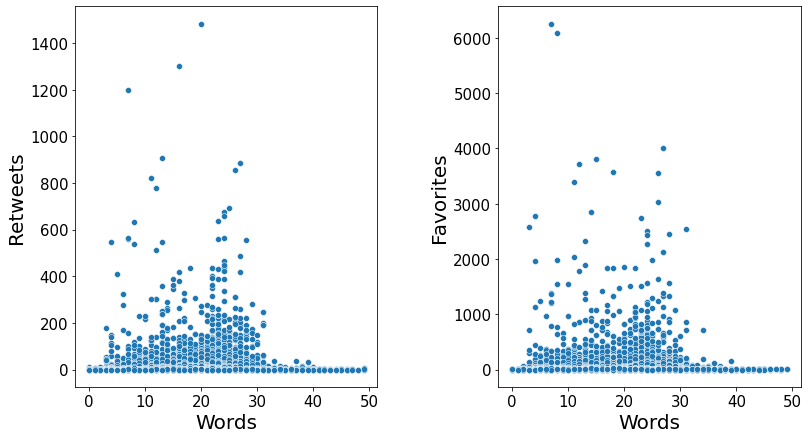

In [90]:
# Remove outliers for better visualizations 
tweets = Tweets[(Tweets["Retweet-Count"] < 2000) & (Tweets.Words < 50) & (Tweets["Favorites"] < 8000)]

fig, (ax1, ax2) =plt.subplots(1,2, sharex=True, figsize = (13,7))
import matplotlib
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

sns.scatterplot(x="Words", y="Retweet-Count", data=tweets, ax = ax1)
sns.scatterplot(x="Words", y="Favorites", data=tweets, ax = ax2)
ax1.set_xlabel('Words', size = 20)
ax2.set_xlabel('Words', size = 20)
ax1.set_ylabel('Retweets', size = 20)
ax2.set_ylabel('Favorites', size = 20)

import matplotlib
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

plt.subplots_adjust(wspace=.4)

On average, tweets with a word count below 30 get more favorites and retweets than tweets with a word count above 40.

In [7]:
# Create our contextual stop words so that these won't be counted in the frequent words list (keywords used to collect tweets)
tfidf_stops = ["online", "class", "course", "learning", "learn","teach", "teaching", "distance", \
               "distancelearning", "education", "teacher", "student", "grade", "classes", "computer", "resource", \
               "onlineeducation", "onlinelearning", "school", "students", "class", "virtual", "eschool", "thing", \
               "virtuallearning", "educated", "educates", "teaches", "studies", "study", "semester", "elearning", \
               "teachers", "lecturer", "lecture", "amp", "academic", "admission", "academician", "account", "action",\
               "add", "app", "announcement", "application", "adult", "classroom", "system", "video", "essay", "training", \
               "homework","work","assignment", "paper", "get", "math", "project", "science", "physics", "lesson", "schools", \
               "courses", "assignments", "know", "instruction","email", "discussion","home", "college", "exam", "university", \
               "use", "fall", "term", "proposal", "one", "review", "proposal", "calculus", "search", "research", "algebra", \
               "internet", "remote", "remotelearning"]

What are the most commonly used words?

In [12]:
# Combine all tweets as one big text for vectorizer
tweets_combined = " ".join(t for t in Tweets.processed_post.values)
text = []
text.append(tweets_combined)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = CountVectorizer(encoding='latin-1')
# Now X is the document-term matrix. 
x = vectorizer.fit_transform(text)

vectorizer = CountVectorizer(max_features=100, encoding='latin-1', stop_words = tfidf_stops)
x = vectorizer.fit_transform(text)
dt = pd.DataFrame(x.toarray().transpose(), index = vectorizer.get_feature_names())
dt = dt.sort_values(by=[0], ascending = False)
dt.rename(columns = {0:'count'}, inplace = True) 
dt[:20]

,count
pay,18676
help,13237
new,10783
free,9955
time,9746
like,9542
kids,9391
need,9133
covid,8572
year,8517


Word cloud of most common words

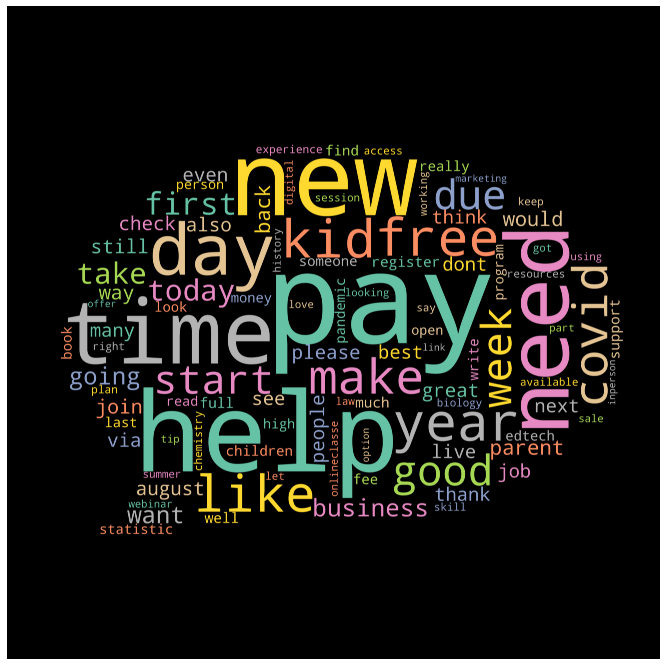

In [13]:
mask = np.array(Image.open("comment.png"))
wordcloud = WordCloud(mask=mask, stopwords = tfidf_stops, max_font_size = 400, max_words=100,
                      width = 800, height = 800, scale = 6, collocations=False, colormap='Set2',
                      background_color = 'black').generate(tweets_combined)


plt.figure(figsize=(20, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

What words appear together frequently? 

In [14]:
words_in_post = [post.lower().split() for post in text]
posts = [[word for word in post_words if word not in tfidf_stops] for post_words in words_in_post]
# Create list of lists containing bigrams in posts
terms_bigram = [list(bigrams(post)) for post in posts]

In [15]:
# Begin by flattening the list of bigrams. You can then create the
# counter and query the top 20 most common bigrams across the posts.
# Flatten list of bigrams in clean posts
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_df = pd.DataFrame(bigram_counts.most_common(20),columns=['bigram', 'count'])
bigram_df

,bigram,count
0,"(pay, pay)",3072
1,"(pay, someone)",2596
2,"(someone, write)",1948
3,"(due, pay)",1903
4,"(first, day)",1771
5,"(statistics, biology)",1756
6,"(business, law)",1670
7,"(nursing, due)",1576
8,"(pay, due)",1387
9,"(pay, full)",1383


3 of the top 5 most common bigrams include the the word "pay".

# 3. Sentiment Analysis
Use TextBlob to get polarity and subjectivity scores

In [7]:
def get_sentiment(post): 
    blob = TextBlob(post) 
    return blob.sentiment 

from textblob import TextBlob
# Get sentiment and append into dataframe
polarity = []
subjectivity = []
for post in Tweets['processed_post']:
    polar = get_sentiment(post).polarity
    polarity.append(polar)
    subjec = get_sentiment(post).subjectivity
    subjectivity.append(subjec)
    
Tweets['polarity'] = polarity
Tweets['subjectivity'] = subjectivity

In [8]:
# Classify tweets as positive, negative, or neutral based on polarity
polarity = [None] * len(Tweets) 

for i in range(0, len(Tweets)):
    if Tweets["polarity"][i] > 0:
        polarity[i] = "Positive"
    elif Tweets["polarity"][i] == 0:
        polarity[i] = "Neutral"
    else:
        polarity[i] = "Negative"

Tweets["Label"] = polarity

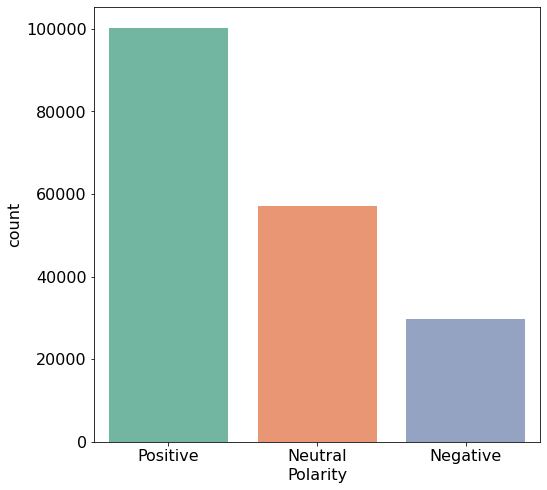

In [37]:
# Examine distribution of tweet sentiments
import seaborn as sns 
import matplotlib.pyplot as plt 

plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 16})
ax = sns.countplot(x ='Label', data = Tweets, palette = "Set2")
ax.set(xlabel='Polarity')
plt.show()

There were more positive tweets about distance learning than negative tweets about distance learning.

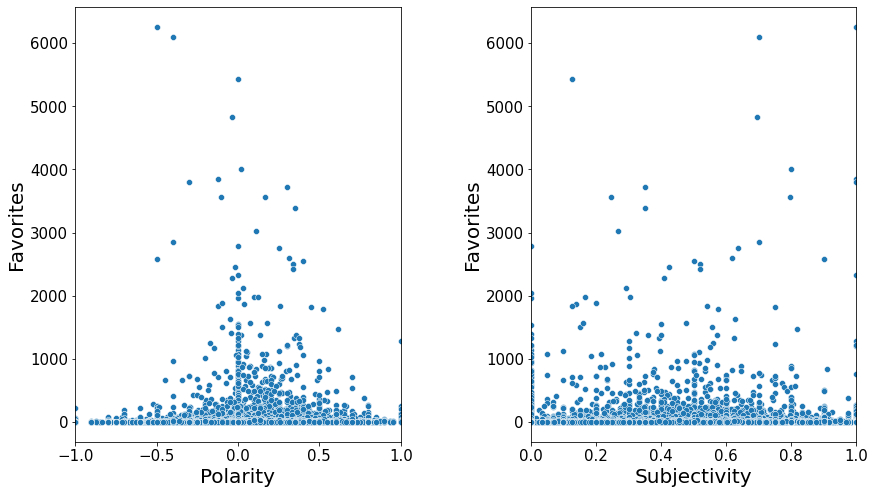

In [111]:
# Remove outliers from favorites for a better visualization
# of the relationship between favorites and polarity
favorites = Tweets[Tweets["Favorites"] < 8000]

# plt.figure(figsize=(8,8))
# plt.rcParams.update({'font.size': 16})
# sns.relplot(x="polarity", y="Favorites", data=favorites)
# sns.relplot(x="subjectivity", y="Favorites", data=favorites)

fig, (ax1, ax2) =plt.subplots(1,2, figsize = (14,8))
import matplotlib
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

sns.scatterplot(x="polarity", y="Favorites", data=favorites, ax = ax1)
ax1.set_xlim([-1, 1])
ax1.set_ylabel('Favorites', size = 20)
ax1.set_xlabel('Polarity', size = 20)
ax1.set_xbound(lower=-1, upper=1)

sns.scatterplot(x="subjectivity", y="Favorites", data=favorites, ax = ax2)
ax2.set_xlim([0, 1])
ax2.set_xlabel('Subjectivity', size = 20)
ax2.set_ylabel('Favorites', size = 20)
ax2.set_xbound(lower=0, upper=1)



plt.subplots_adjust(wspace=.4)

Neutral tweets appear to get more favorites than tweets with high polarity.
There does not appear to be an association between subjectivity and the number of favorites a tweet has.

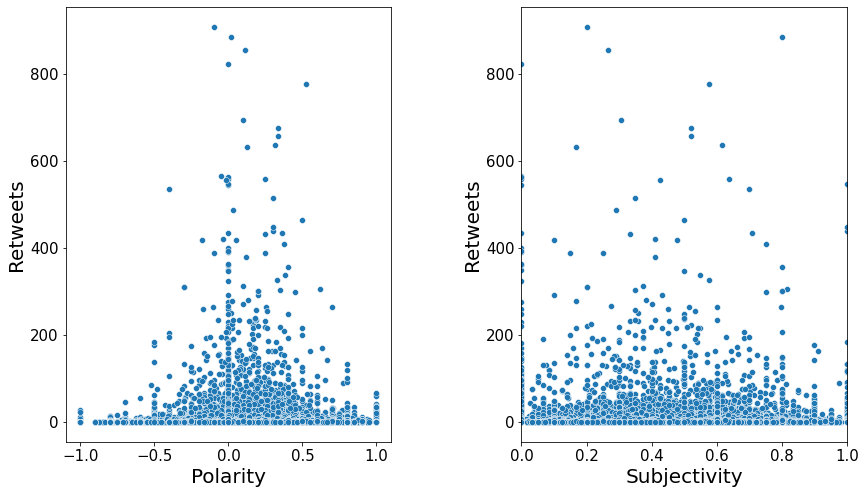

In [116]:
retweets = Tweets[Tweets["Retweet-Count"] < 1000]


fig, (ax1, ax2) =plt.subplots(1,2, figsize = (14,8))
import matplotlib
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

sns.scatterplot(x="polarity", y="Retweet-Count", data=retweets, ax = ax1)
sns.scatterplot(x="subjectivity", y="Retweet-Count", data = retweets, ax = ax2)

ax1.set_xlabel('Polarity', size = 20)
ax2.set_xlabel('Subjectivity', size = 20)
ax1.set_ylabel('Retweets', size = 20)
ax2.set_ylabel('Retweets', size = 20)
ax2.set_xbound(lower=0, upper=1)

import matplotlib
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

plt.subplots_adjust(wspace=.4)

Similar to favorites, the retweet count is greater for neutral tweets than highly polar tweets.
Retweet count does not appear to have any correlation with tweet subjectivity.

Text(0, 0.5, 'Subjectivity')

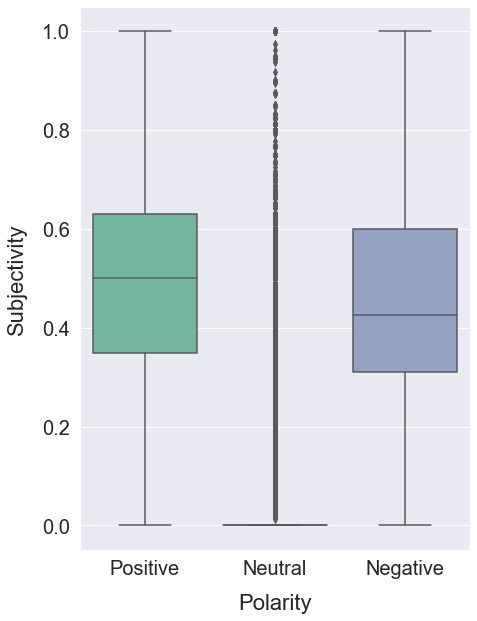

In [206]:
# Examine the relationship between subjectivity and polarity
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize = (7,10))

sns.boxplot(x="Label", y="subjectivity", data=Tweets, palette = "Set2", ax = ax)

plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
ax.set_xlabel('Polarity', size = 22, labelpad = 15)
ax.set_ylabel('Subjectivity', size = 22, labelpad = 15)


On average, positive tweets are more subjective than negative tweets.¶

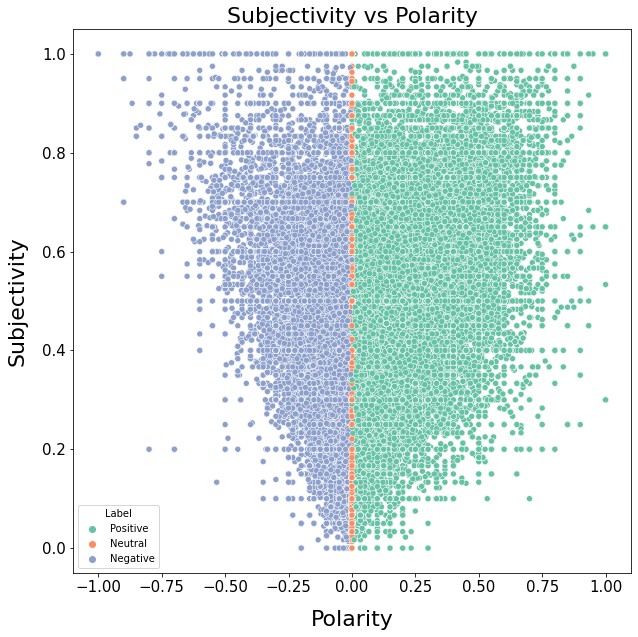

In [16]:
# Visualize the Polarity scores
plt.figure(figsize = (10, 10)) 
sns.scatterplot(x="polarity", y="subjectivity", hue="Label", data=Tweets, palette = "Set2")
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.xlabel('Polarity', size = 22, labelpad = 15)
plt.ylabel('Subjectivity', size = 22, labelpad = 15)
plt.title("Subjectivity vs Polarity", size = 22)
plt.show()

### Examine positive and negative wordclouds

In [186]:
# Look at popular words for positive and negative tweets
# Create DataFrames for each label
positive_df = Tweets.sort_values(by=["polarity","Favorites","Retweet-Count", ], axis=0,
    ascending=[False, False, False])[["Content","Retweet-Count","Favorites","polarity","processed_post"]].head(50)

negative_df = Tweets.sort_values(by=["polarity", "Favorites", "Retweet-Count"], axis=0, 
    ascending=[True, False, False])[["Content","Retweet-Count","Favorites","polarity","processed_post"]].head(50)

objective_df = Tweets.sort_values(by=["subjectivity","Favorites","Retweet-Count", ], axis=0,
    ascending=[True, False, False])[["Content","Retweet-Count","Favorites","subjectivity","processed_post"]].head(30)

subjective_df = Tweets.sort_values(by=["subjectivity","Favorites","Retweet-Count", ], axis=0,
    ascending=[False, False, False])[["Content","Retweet-Count","Favorites","subjectivity","processed_post"]].head(30)

posts = positive_df.processed_post.values
positive_text = " ".join(t for t in posts)

posts = negative_df.processed_post.values
negative_text = " ".join(t for t in posts)

posts = subjective_df.processed_post.values
subjective_text = " ".join(t for t in posts)

posts = objective_df.processed_post.values
objective_text = " ".join(t for t in posts)

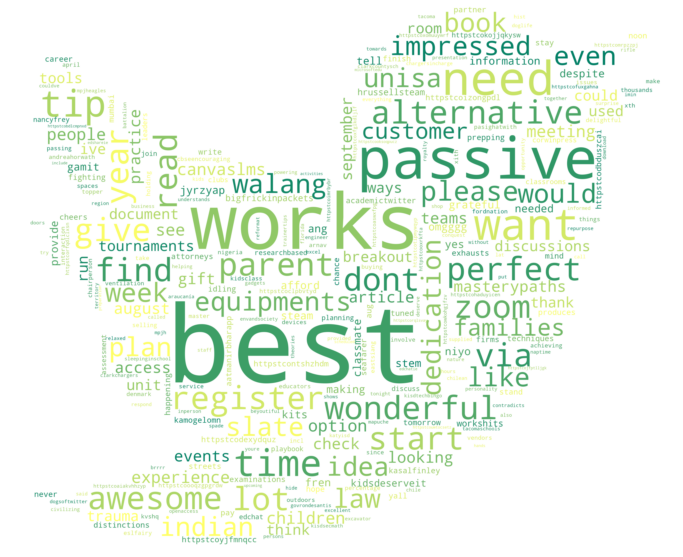

In [195]:
# Positive tweets
mask = np.array(Image.open("Unknown.png"))

wordcloud = WordCloud(mask = mask, stopwords = tfidf_stops, max_font_size=110, max_words = 300, width = 400, height = 300, background_color = 'white',
                      scale = 6, collocations=False, colormap = 'summer').generate(positive_text)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

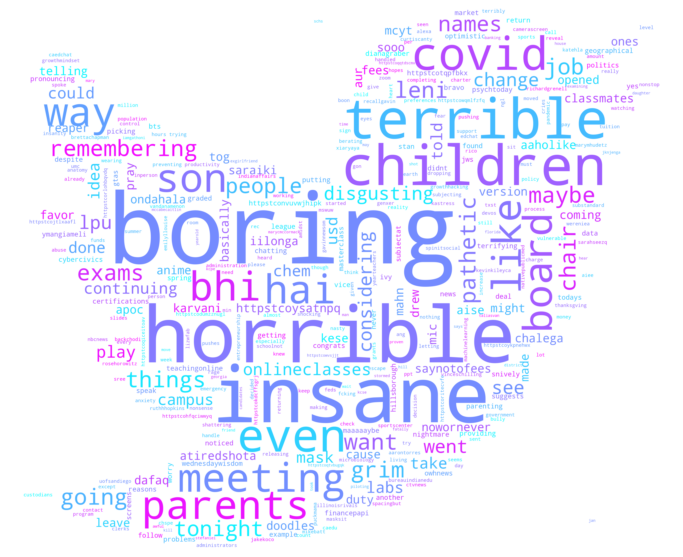

In [197]:
# Negative Tweets
mask = np.array(Image.open("Unknown.png"))

wordcloud = WordCloud(mask = mask, stopwords = tfidf_stops, max_font_size=100, max_words = 500, width = 400, height = 300, background_color = 'white',
                      scale = 6, collocations=False, colormap = 'cool').generate(negative_text)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Topic Modeling - LDA

Create a function to pre-process tweets for LDA

In [8]:
def LDAPreprocessing(text): 
    # get lowercase
    text = text.lower()
    # remove numbers    # remove numbers

    text = re.sub(r'\d+', '', text)
    # remove urls
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)
    # remove punctuation
    text = text.translate(text.maketrans('', '', string.punctuation))
    # strip whitespace
    text = text.strip()
    # remove stop words
    stop_words = stopwords.words('english')
    newStopWords = tfidf_stops
    stop_words.extend(newStopWords)
    stop_words = set(stop_words)
    tokens = word_tokenize(text)
    words = [w for w in tokens if not w in stop_words]
    text = " ".join(w for w in words)
    
    # Remove non-alphabetic characters and keep the words contains three or more letters
    tokens = word_tokenize(text)
    words = [w for w in tokens if w.isalpha() and len(w)>2]
    text = " ".join(w for w in words)

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    words = [lemmatizer.lemmatize(w, pos = 'a') for w in tokens]
    result = " ".join(w for w in words)
    return result

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [10]:
# preprocess posts
posts = Tweets.Content.values
processed_posts = [LDAPreprocessing(text) for text in posts]
posts_words = list(sent_to_words(processed_posts))

# Do lemmatization keeping only noun, adj, vb, adv
posts_lemmatized = lemmatization(posts_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Gensim creates a unique id for each word in the document. The produced corpus shown below is a mapping of (word_id, word_frequency).

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(posts_lemmatized)
# Create Corpus
texts = posts_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


### Base Model
You can select the number of topics you would like to have. In addition to seleciting the number of topics alpha and eta are hyperparameters that affect sparsity of the topics. (both defaults to 1.0/num_topics).

In [231]:
# Build LDA model
# chunksize (int, optional) – Number of documents to be used in each training chunk.
# passes (int, optional) – Number of passes through the corpus during training.

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=4, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [232]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())

[(0, '0.013*"go" + 0.012*"year" + 0.011*"make" + 0.011*"time" + 0.011*"kid" + 0.010*"take" + 0.009*"good" + 0.009*"start" + 0.009*"need" + 0.009*"get"'), (1, '0.013*"new" + 0.009*"check" + 0.008*"help" + 0.008*"great" + 0.008*"create" + 0.007*"resource" + 0.007*"share" + 0.007*"take" + 0.007*"find" + 0.006*"skill"'), (2, '0.012*"free" + 0.011*"job" + 0.011*"make" + 0.009*"session" + 0.009*"start" + 0.008*"money" + 0.008*"offer" + 0.008*"join" + 0.007*"week" + 0.007*"look"'), (3, '0.067*"pay" + 0.031*"fee" + 0.024*"due" + 0.020*"tuition" + 0.019*"full" + 0.019*"write" + 0.017*"help" + 0.016*"conduct" + 0.015*"whole" + 0.013*"amount"')]


In [233]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=posts_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.30320278240276244


In [1]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

NameError: name 'pyLDAvis' is not defined

### Hyperparameter Tuning and Model Evaluation
You can test models with different parameters to see what parameter values create a model with the best coherence score.

In [202]:
# put previous process into a function
def compute_coherence_values(corpus, id2word, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=posts_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [203]:
# Topics range
min_topics = 4
max_topics = 6
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.5))
alpha.append('symmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.5))
beta.append('symmetric')

num_of_docs = len(corpus)
model_results = {'Topics': [], 'Alpha': [],'Beta': [],'Coherence': []}

Run different models with each pares of topics and hyperparameters and show coherence scores

In [204]:
# iterate through number of topics
for k in topics_range:
    # iterate through alpha values
    for a in alpha:
        # iterare through beta values
        for b in beta:
            # get the coherence score for the given parameters
            cv = compute_coherence_values(corpus=corpus, id2word=id2word, 
                                          k=k, a=a, b=b)
            # Save the model results
            model_results['Topics'].append(k)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)

results_df = pd.DataFrame(model_results)

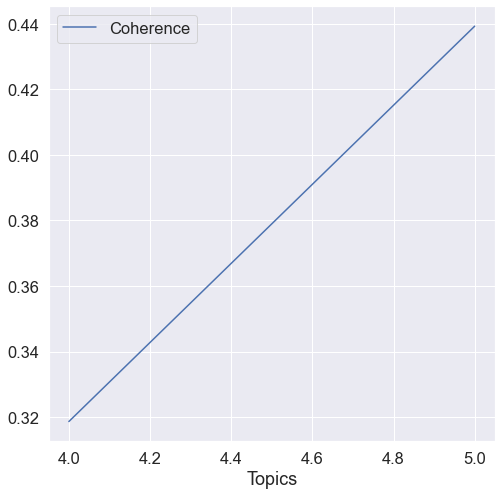

In [228]:
# for each topic, find the maximum coherence score and plot
plt.rcParams["figure.figsize"] = [8,8]
ax = results_df.groupby(['Topics'], as_index=False)['Coherence'].max().plot(x='Topics', y='Coherence', rot=0)


From looking at the graph, we can select a topic number and find the best hyperparameters. (5 topics appears to be best)

In [230]:
results_df[results_df['Topics'] == 5].sort_values(by='Coherence', ascending=False)

,Topics,Alpha,Beta,Coherence
10,5,0.01,0.51,0.439272
13,5,0.51,0.51,0.370878
14,5,0.51,symmetric,0.352452
16,5,symmetric,0.51,0.344518
11,5,0.01,symmetric,0.341717
12,5,0.51,0.01,0.333967
15,5,symmetric,0.01,0.311864
17,5,symmetric,symmetric,0.303119
9,5,0.01,0.01,0.284936


In [229]:
results_df[results_df['Topics'] == 4].sort_values(by='Coherence', ascending=False)

,Topics,Alpha,Beta,Coherence
2,4,0.01,symmetric,0.318655
1,4,0.01,0.51,0.316694
0,4,0.01,0.01,0.311936
3,4,0.51,0.01,0.311215
8,4,symmetric,symmetric,0.297239
7,4,symmetric,0.51,0.293404
5,4,0.51,symmetric,0.291015
4,4,0.51,0.51,0.274048
6,4,symmetric,0.01,0.247231


Finally, we use the optimal topic number and parameters to build the final model.

In [12]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=.51)

In [13]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.252524  0.043411       1        1  44.272053
0     -0.211836 -0.061987       2        1  37.179996
1      0.188288 -0.099539       3        1   7.754702
3      0.138802  0.234666       4        1   5.595949
2      0.137270 -0.116550       5        1   5.197301, topic_info=             Term          Freq         Total Category  logprob  loglift
1900          pay  13037.000000  13037.000000  Default  30.0000  30.0000
1797          due   5251.000000   5251.000000  Default  29.0000  29.0000
4183          fee   3900.000000   3900.000000  Default  28.0000  28.0000
876          full   4298.000000   4298.000000  Default  27.0000  27.0000
621         write   4185.000000   4185.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
42    educational    299.492615    898.178162   Topic5  -5.7579   1.8588
1797          due    378.371063   5251.701172   Topic5  -5.5241   0.3266
217          high    336.501434   2924.788086   Topic5  -5.6413   0.7947
2213   government    291.374817    970.466309   Topic5  -5.7853   1.7539
206        market    282.206390    929.561646   Topic5  -5.8173   1.7650

[307 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
135       1  0.298880   access
135       2  0.502165   access
135       3  0.000390   access
135       5  0.198213   access
1562      1  0.003061  account
...     ...       ...      ...
621       3  0.838063    write
61        1  0.696906     year
61        2  0.263958     year
61        3  0.000097     year
61        4  0.038990     year

[914 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 2, 4, 3])

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

pyLDAvis.save_html(LDAvis_prepared, "myLDA.html")

In [ ]:
import plotly.io as pio
pio.write_html(LDAvis_prepared, file=’index.html’, auto_open=True)

We can also examine models with other parameters to observe differences. (Topic = 4)

In [19]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.51,
                                           eta='symmetric')

In [20]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.237071  0.017748       1        1  36.613625
2      0.190167 -0.057216       2        1  31.496563
1     -0.239958 -0.267005       3        1  16.723839
3     -0.187281  0.306474       4        1  15.165975, topic_info=       Term          Freq         Total Category  logprob  loglift
1900    pay  17930.000000  17930.000000  Default  30.0000  30.0000
124   start  11610.000000  11610.000000  Default  29.0000  29.0000
61     year  11389.000000  11389.000000  Default  28.0000  28.0000
381     day   8926.000000   8926.000000  Default  27.0000  27.0000
157    week   7966.000000   7966.000000  Default  26.0000  26.0000
...     ...           ...           ...      ...      ...      ...
1332  month   2693.268066   3044.207764   Topic4  -4.6329   1.7636
359   today   5178.972168   6882.526367   Topic4  -3.9791   1.6017
210    plan   3514.378662   4496.020996   Topic4  -4.3668   1.6398
901    book   1912.949951   3380.855957   Topic4  -4.9751   1.3166
748    come   1541.482178   4520.055664   Topic4  -5.1910   0.8103

[211 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
135       2  0.999645      access
1910      4  0.999580  affordable
102       1  0.908953        also
102       2  0.084313        also
102       3  0.006790        also
...     ...       ...         ...
1088      1  0.999888       would
621       3  0.999740       write
2655      4  0.998368     writing
61        1  0.000878        year
61        4  0.999063        year

[279 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])